In [ ]:
!pip install lime shap alibi eli5 artemis pyartemis

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, precision_recall_curve
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.metrics import average_precision_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import shap
import lime
import lime.lime_tabular
import eli5
from eli5.sklearn import PermutationImportance
from alibi.explainers import ALE
from alibi.explainers import plot_ale
import matplotlib.pyplot as plt

In [ ]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=399, test_size=170, random_state=42, stratify=y)

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

In [ ]:
nb_lda = GaussianNB()
nb_lda.fit(X_train_lda, y_train)

y_pred_lda = nb_lda.predict(X_test_lda)

In [ ]:
y_proba_lda = nb_lda.predict_proba(X_test_lda)[:, 1]
y_proba = nb.predict_proba(X_test)[:, 1]

In [ ]:
accuracy = accuracy_score(y_test, y_pred_lda)
precision = precision_score(y_test, y_pred_lda)
recall = recall_score(y_test, y_pred_lda)
f1 = f1_score(y_test, y_pred_lda)
report = classification_report(y_test, y_pred_lda, target_names=data.target_names)

print("Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(report)

Performance Metrics:
Accuracy: 0.9647
Precision: 0.9550
Recall: 0.9907
F1 Score: 0.9725

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.92      0.95        63
      benign       0.95      0.99      0.97       107

    accuracy                           0.96       170
   macro avg       0.97      0.96      0.96       170
weighted avg       0.97      0.96      0.96       170



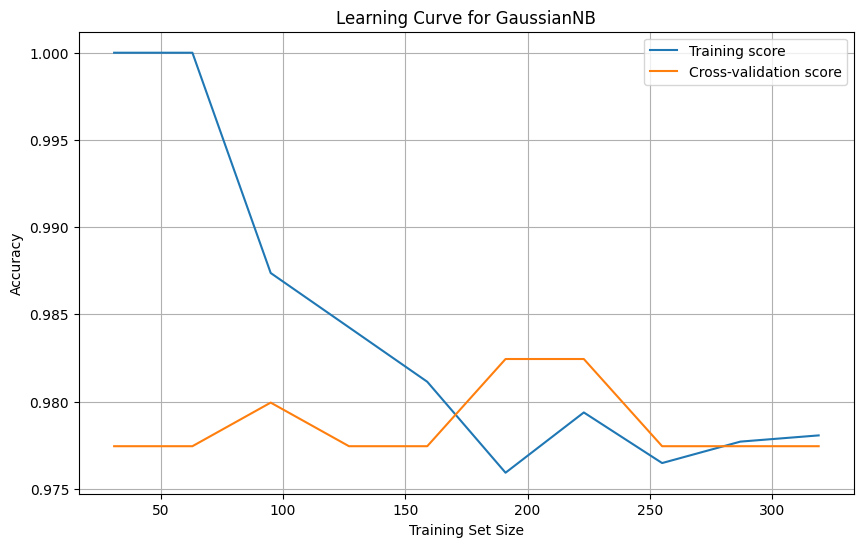

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    GaussianNB(),
    X_train_lda,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, val_scores_mean, label='Cross-validation score')
plt.title('Learning Curve for GaussianNB')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

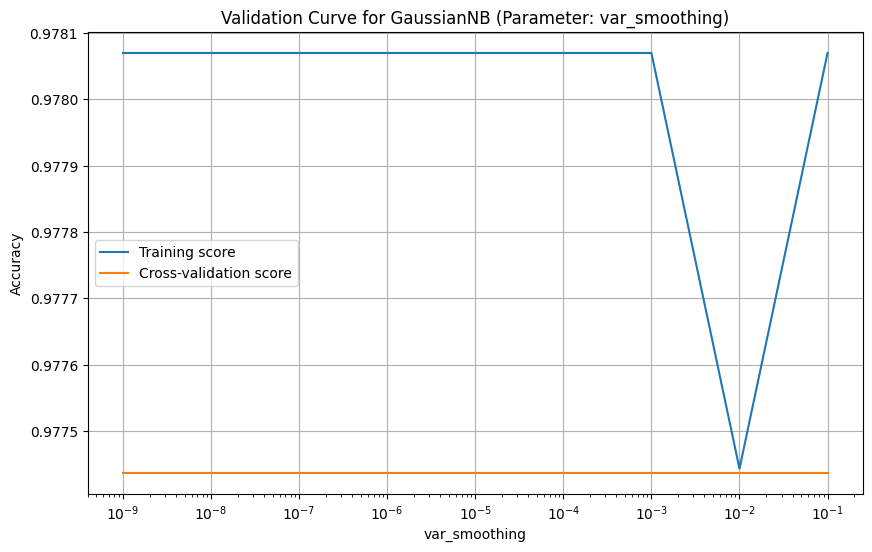

In [ ]:
param_range = np.logspace(-9, -1, 9)
train_scores, val_scores = validation_curve(
    GaussianNB(),
    X_train_lda,
    y_train,
    param_name='var_smoothing',
    param_range=param_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.semilogx(param_range, train_scores_mean, label='Training score')
plt.semilogx(param_range, val_scores_mean, label='Cross-validation score')
plt.title('Validation Curve for GaussianNB (Parameter: var_smoothing)')
plt.xlabel('var_smoothing')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

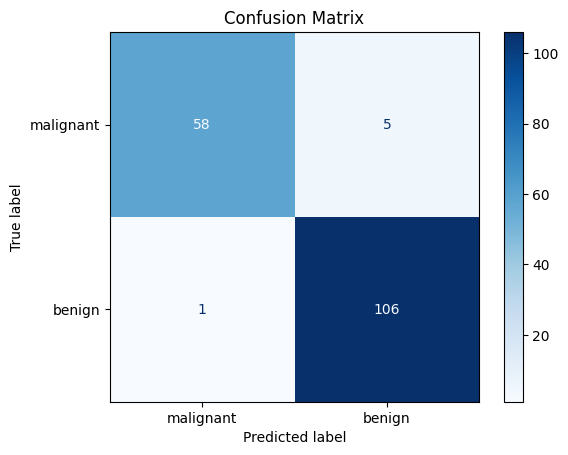

In [ ]:
cm = confusion_matrix(y_test, y_pred_lda)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

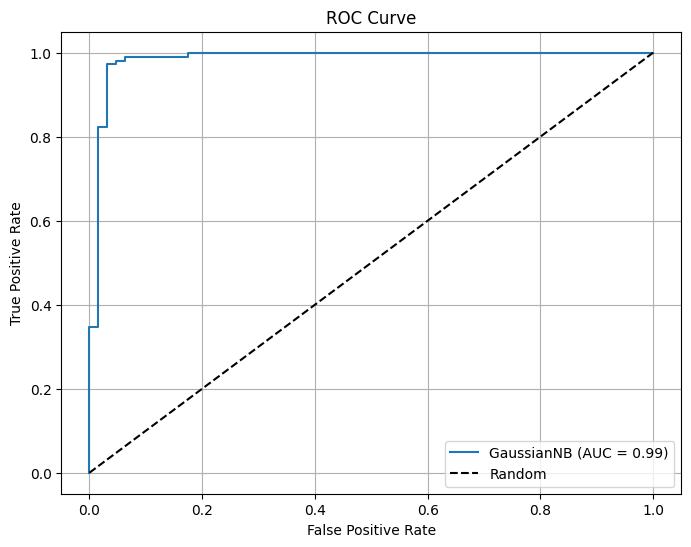

In [ ]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba_lda)
roc_auc = roc_auc_score(y_test, y_proba_lda)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'GaussianNB (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

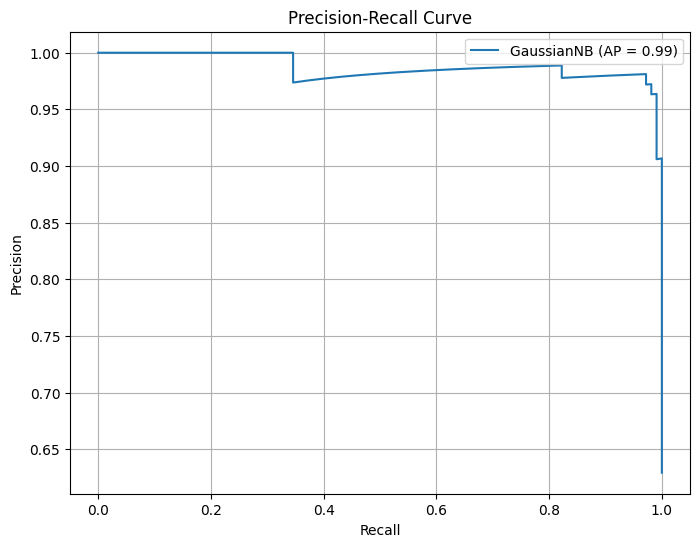

In [ ]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba_lda)
avg_precision = average_precision_score(y_test, y_proba_lda)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'GaussianNB (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

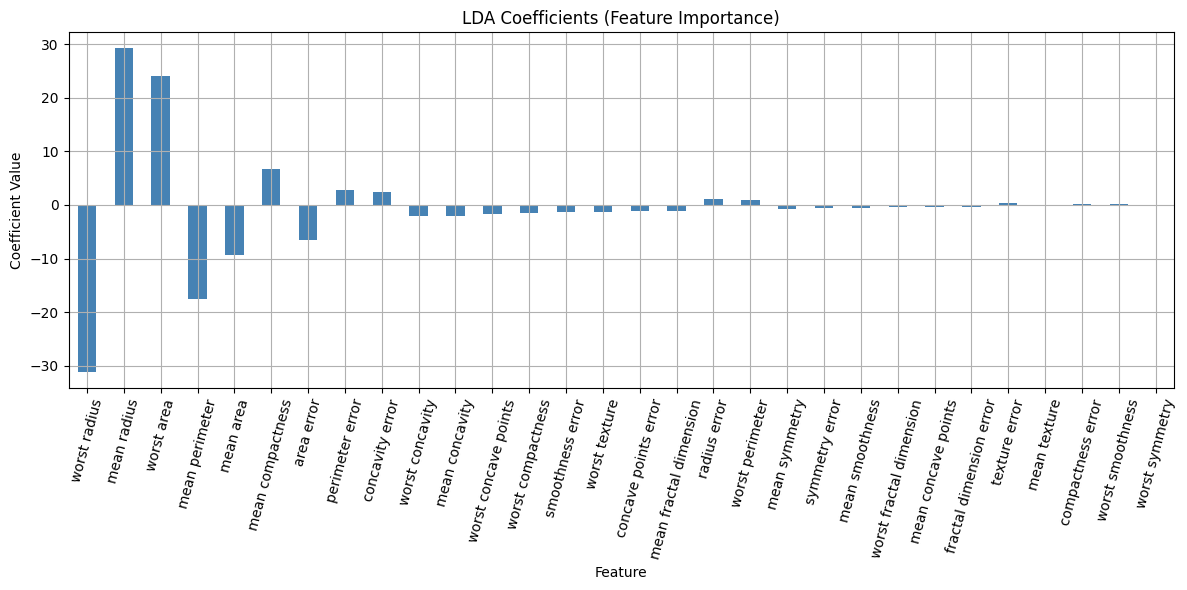

In [ ]:
coefficients = pd.Series(lda.coef_[0], index=X.columns)
coefficients_sorted = coefficients.sort_values(key=abs, ascending=False)

plt.figure(figsize=(12, 6))
coefficients_sorted.plot(kind='bar', color='steelblue')
plt.title('LDA Coefficients (Feature Importance)')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.xticks(rotation=75)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from eli5.sklearn import PermutationImportance
import eli5

perm = PermutationImportance(nb, random_state=42).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=X.columns.tolist())

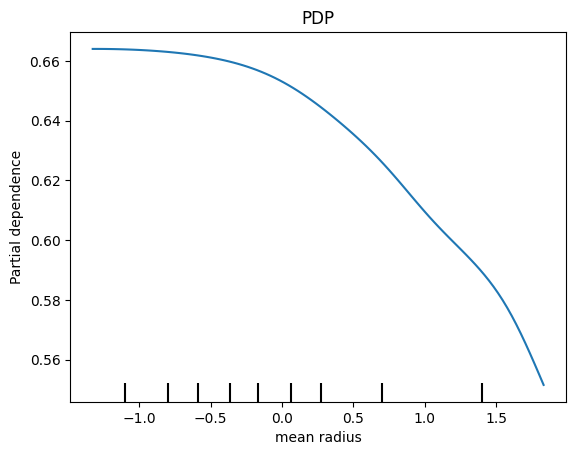

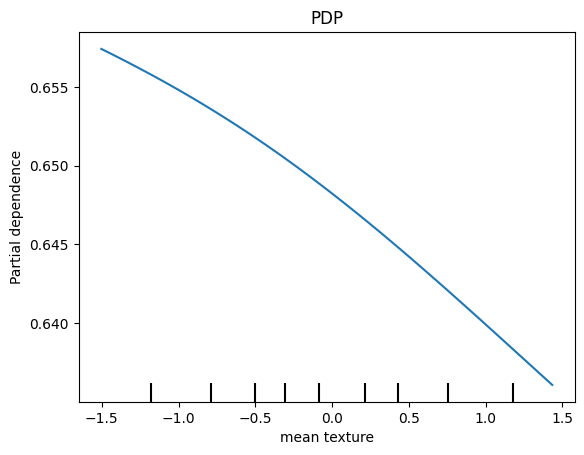

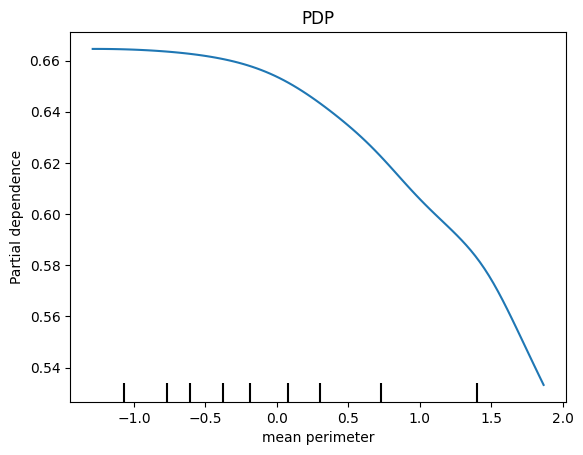

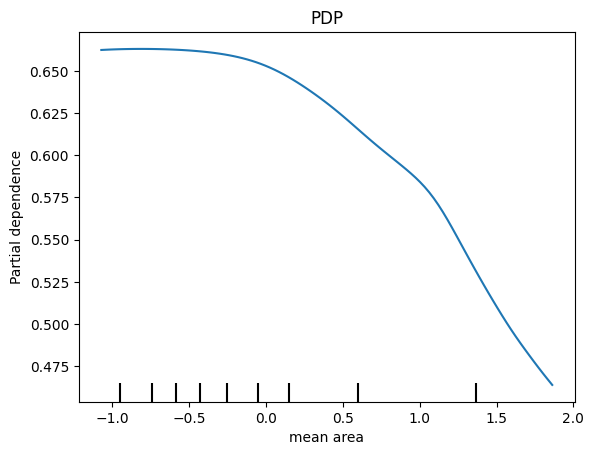

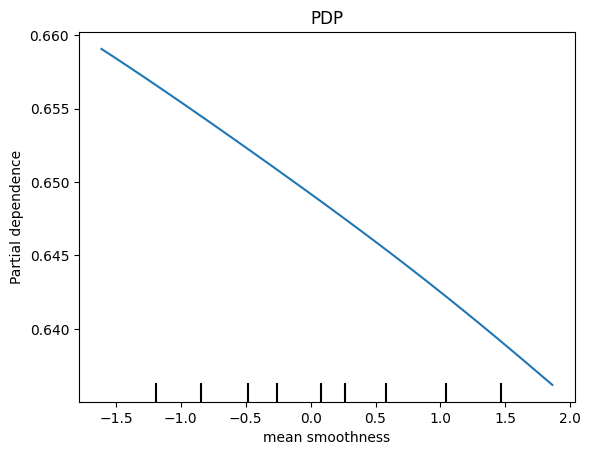

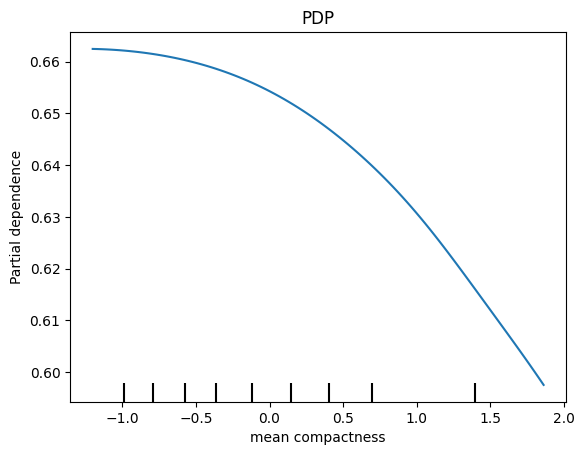

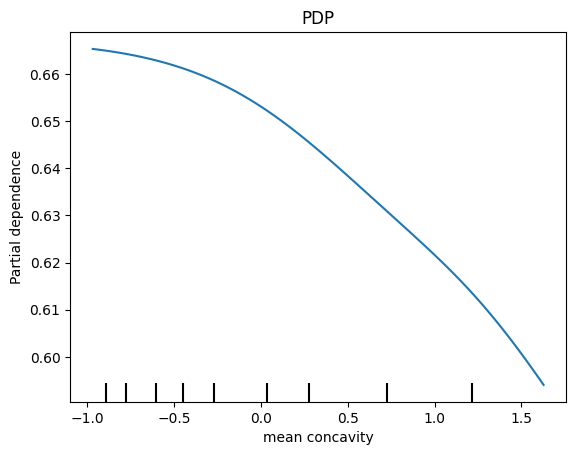

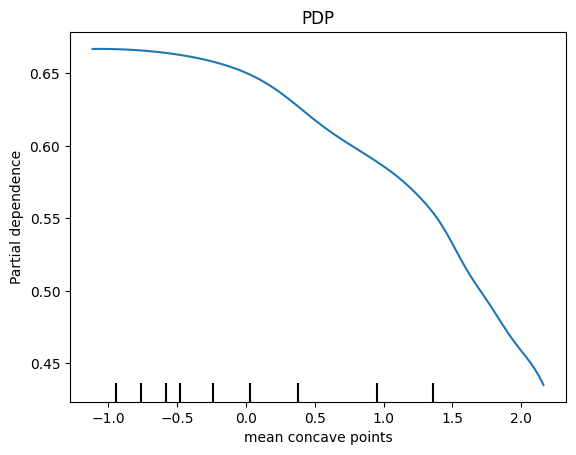

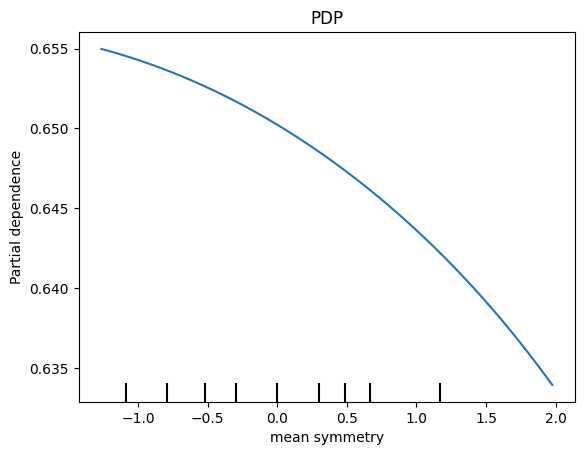

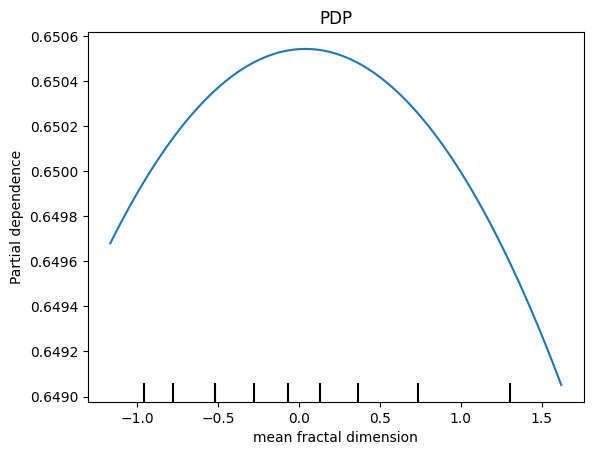

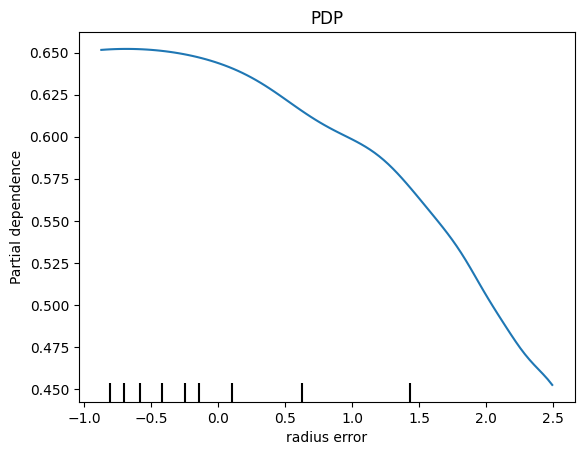

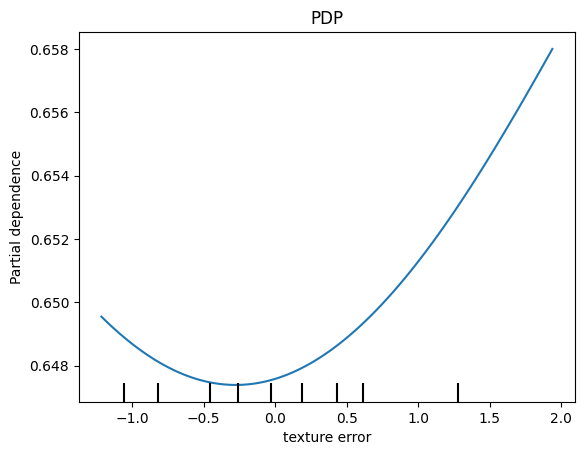

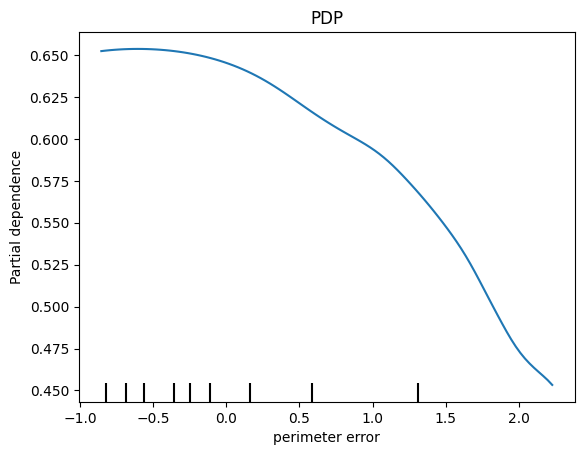

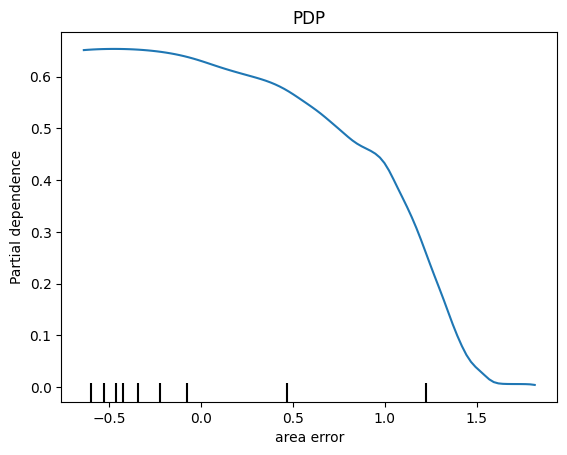

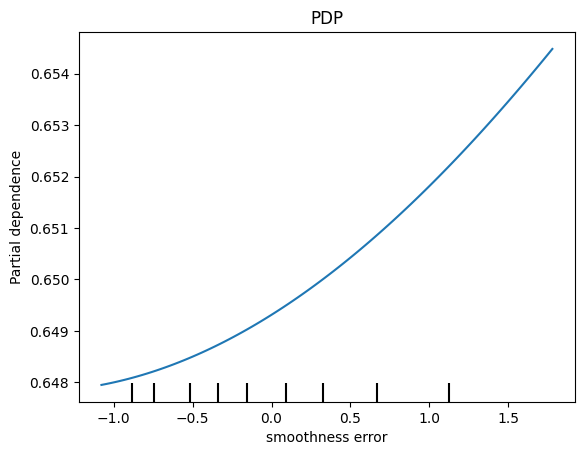

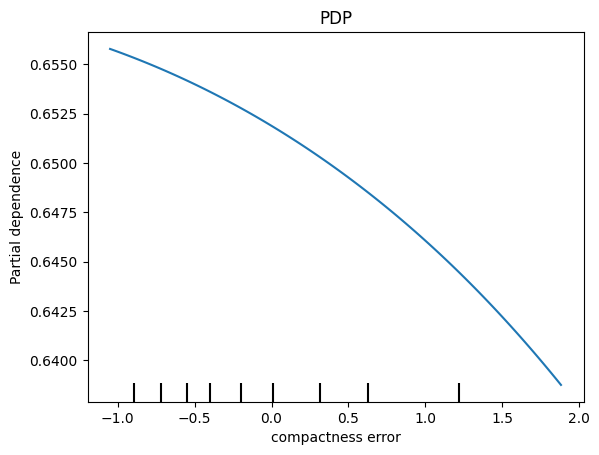

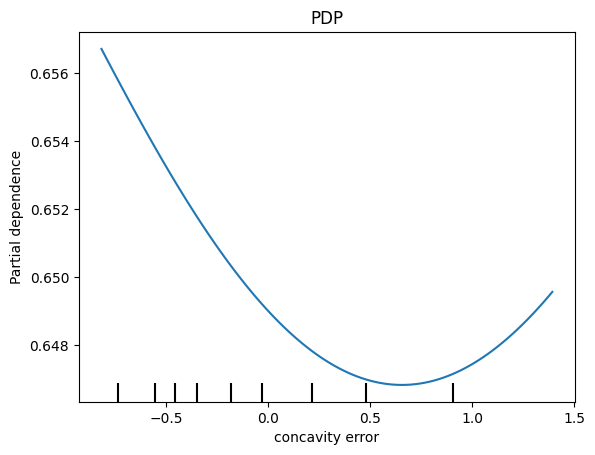

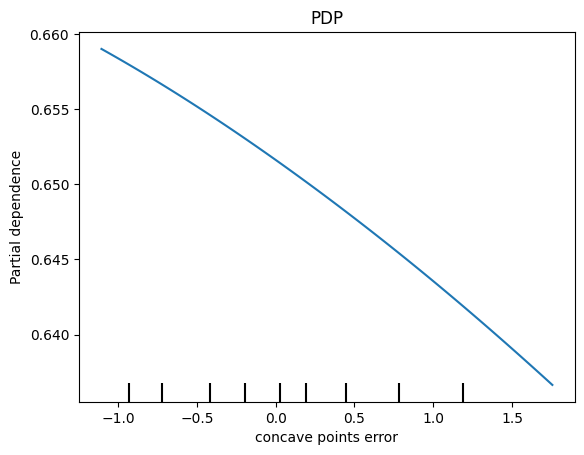

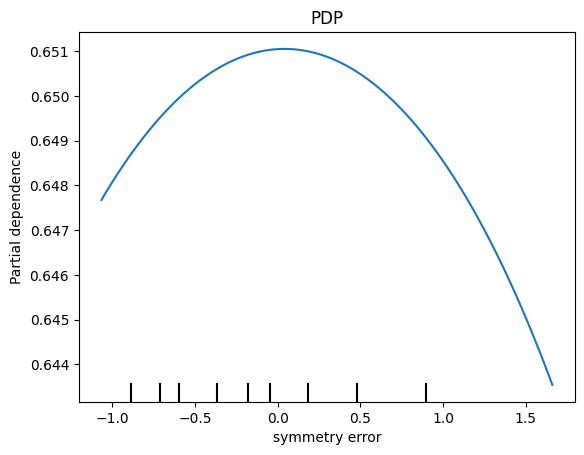

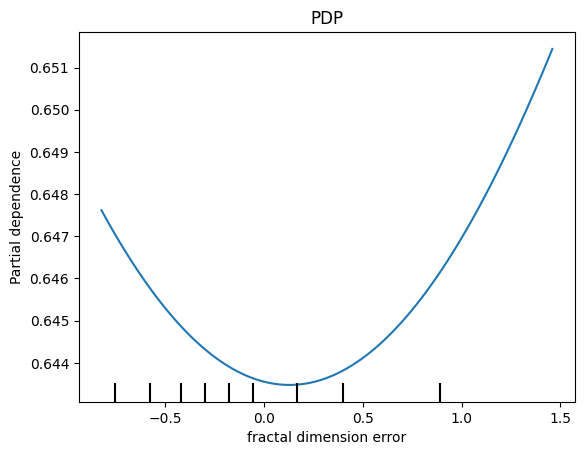

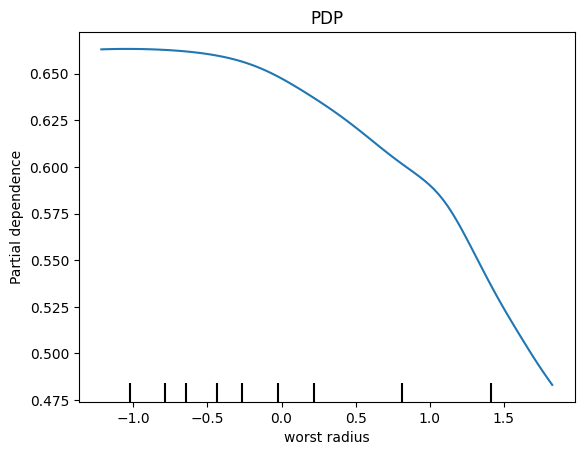

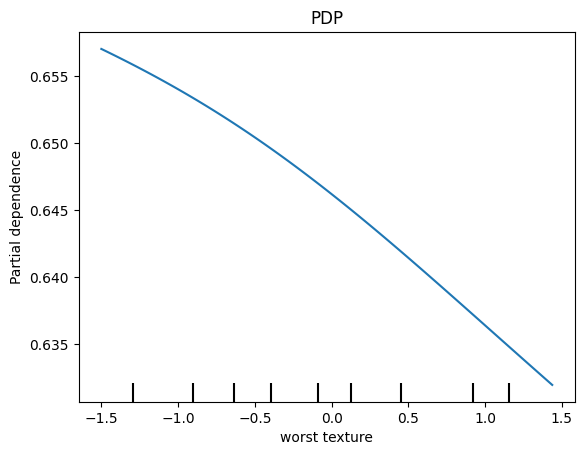

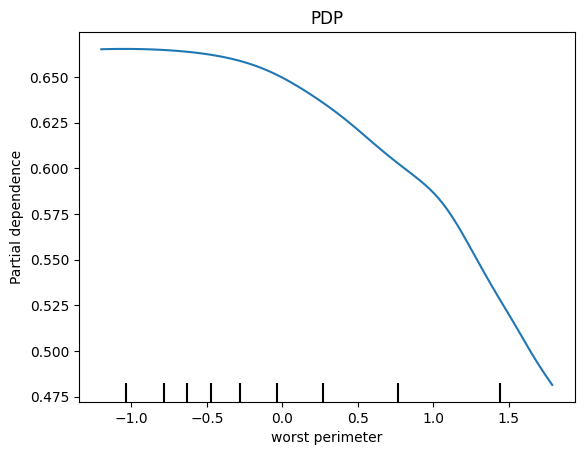

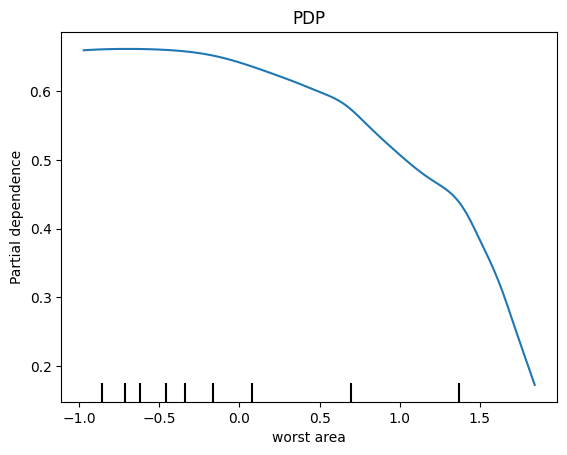

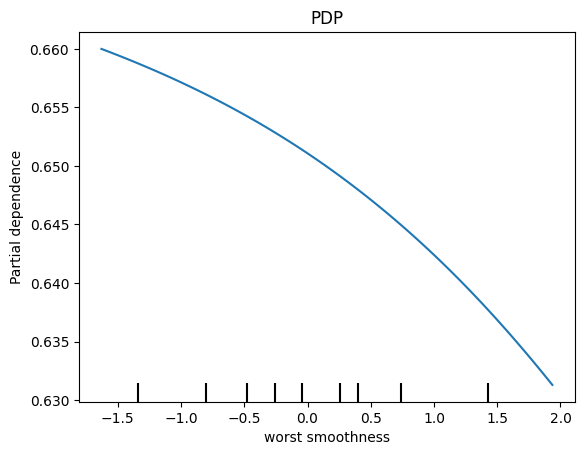

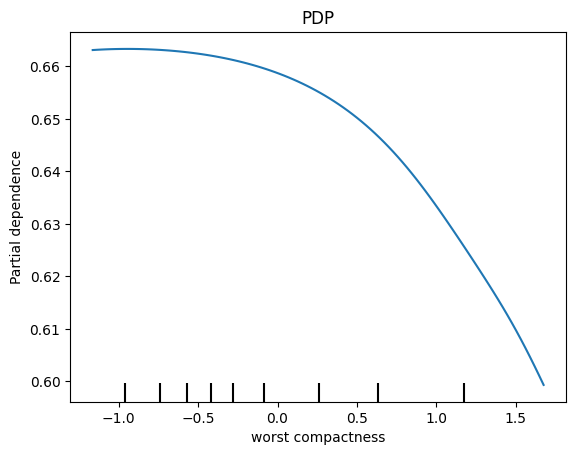

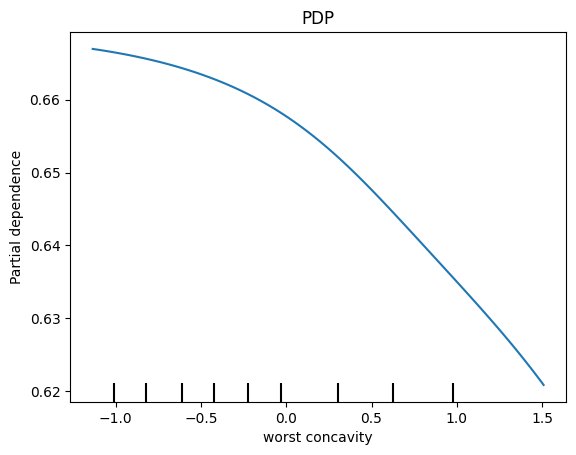

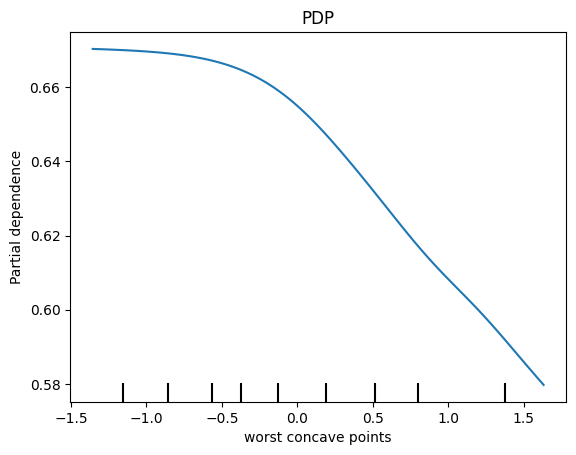

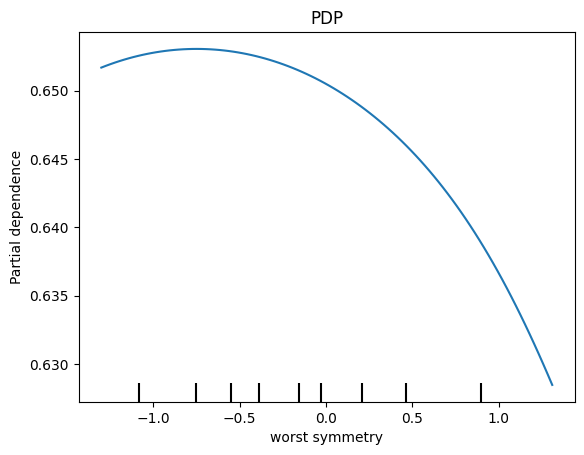

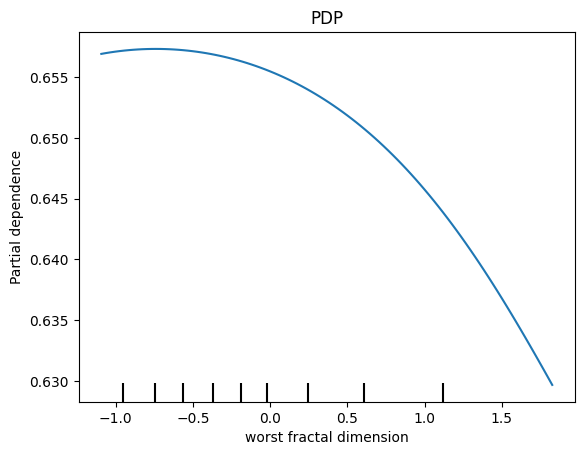

In [ ]:
for feature in X.columns.tolist():
    PartialDependenceDisplay.from_estimator(nb, X_test, features=[feature], target=0, feature_names=X.columns.tolist())
    plt.title("PDP")
    plt.show()

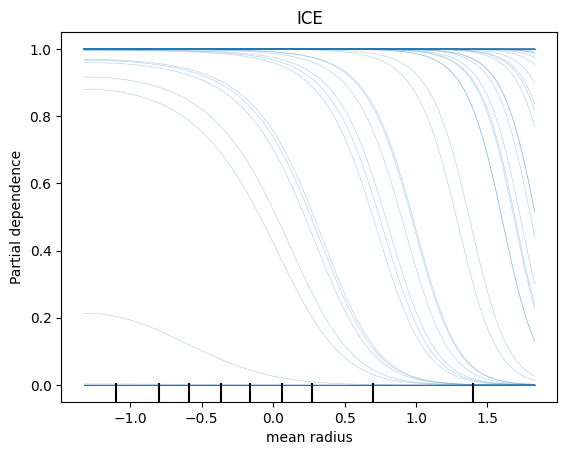

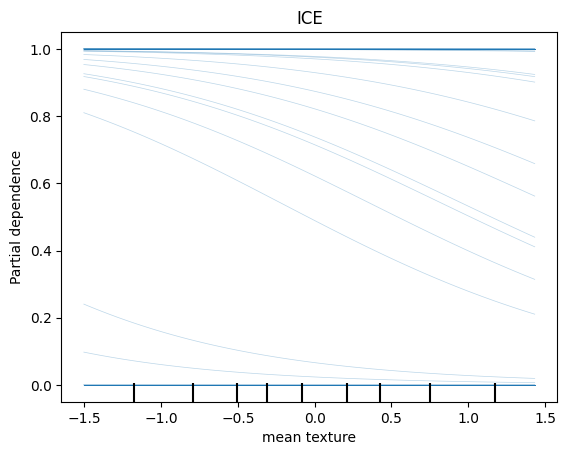

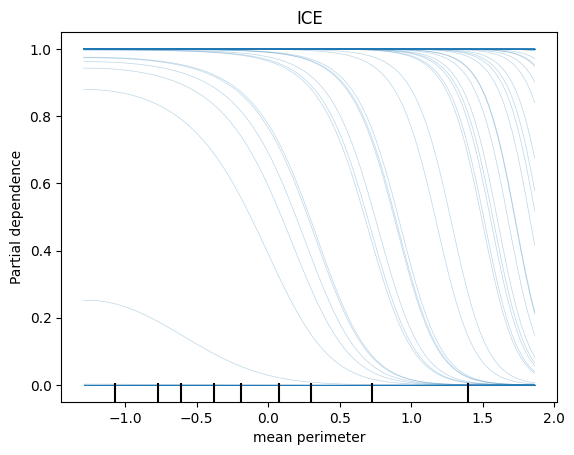

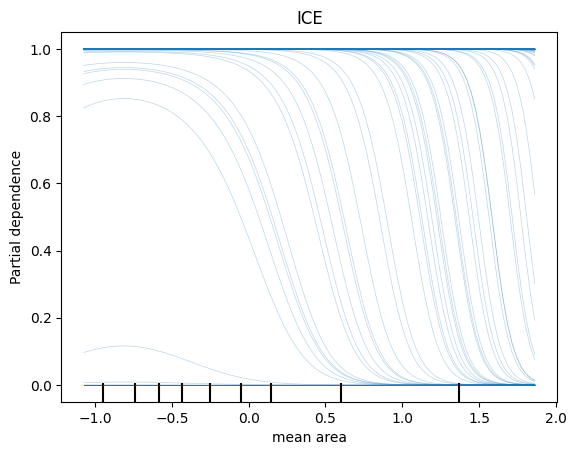

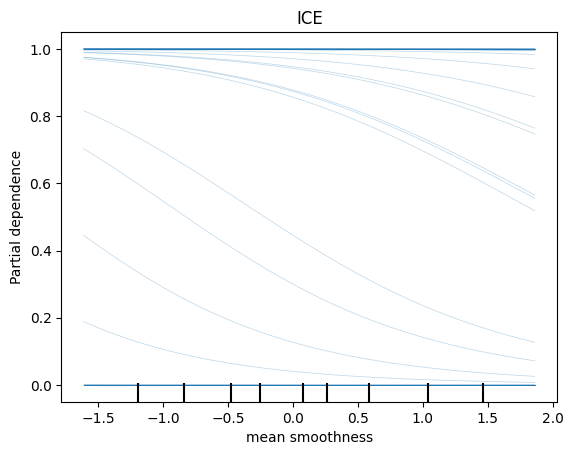

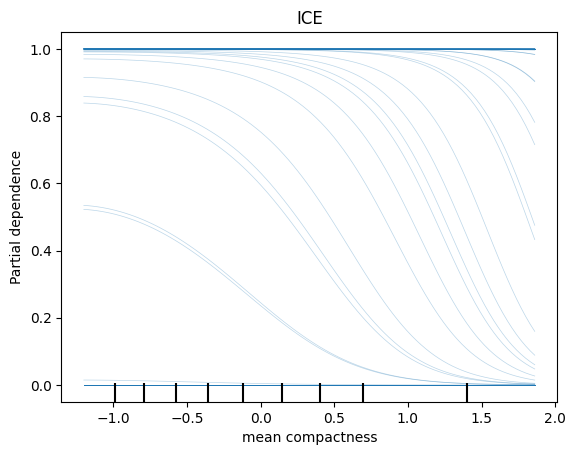

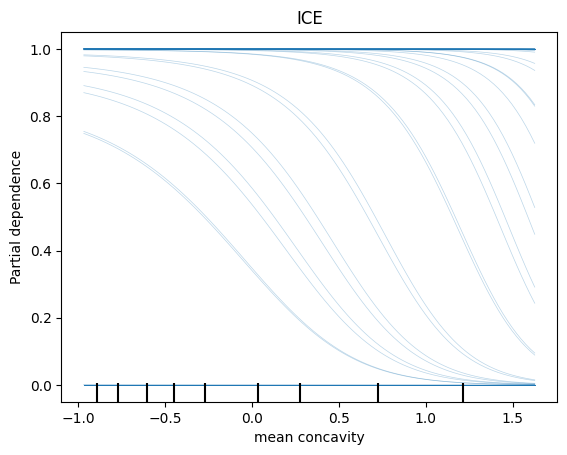

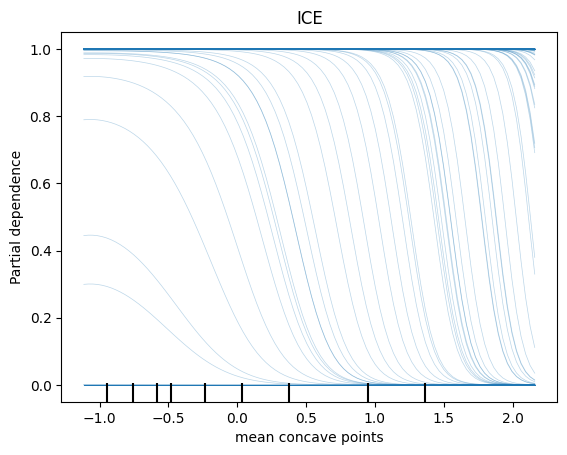

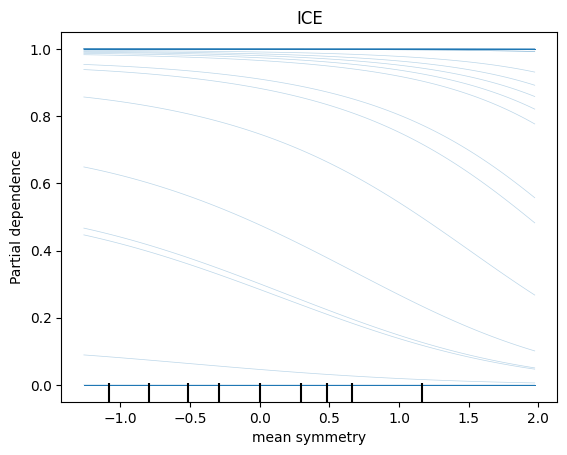

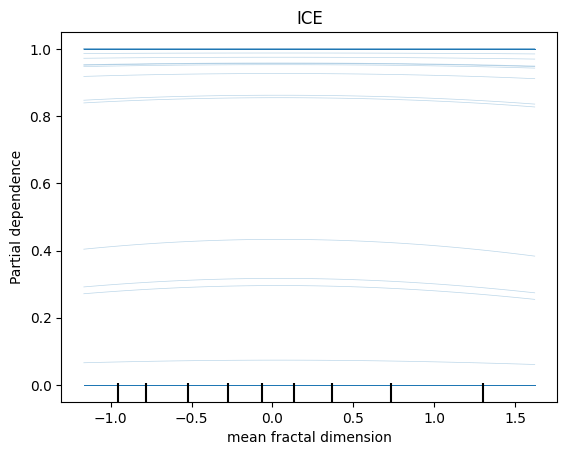

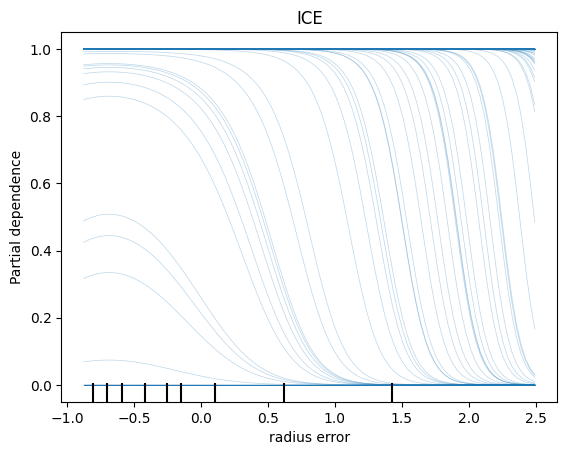

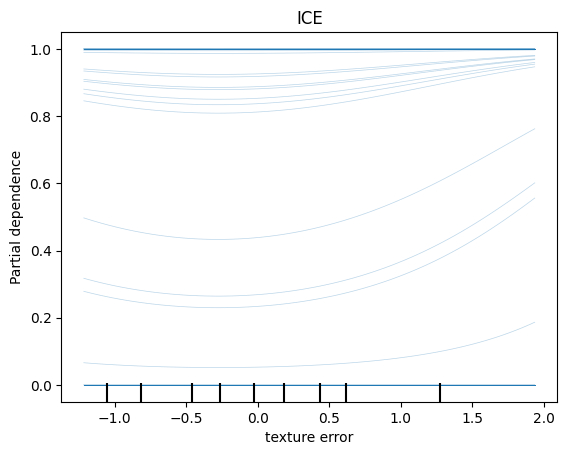

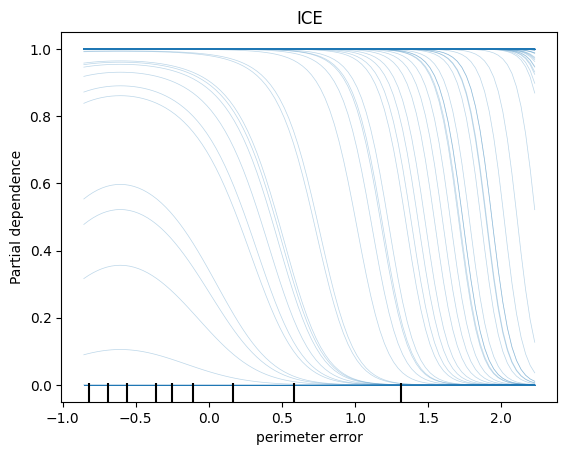

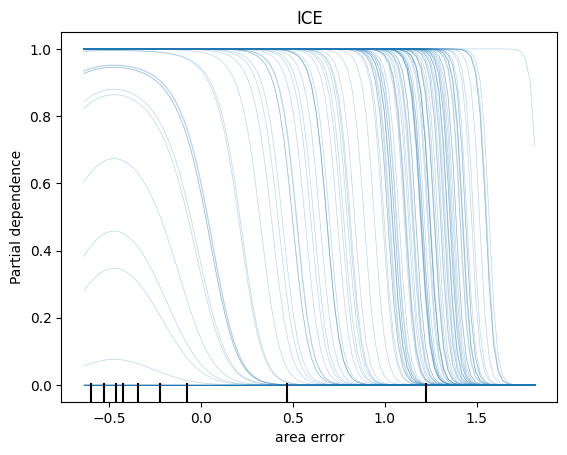

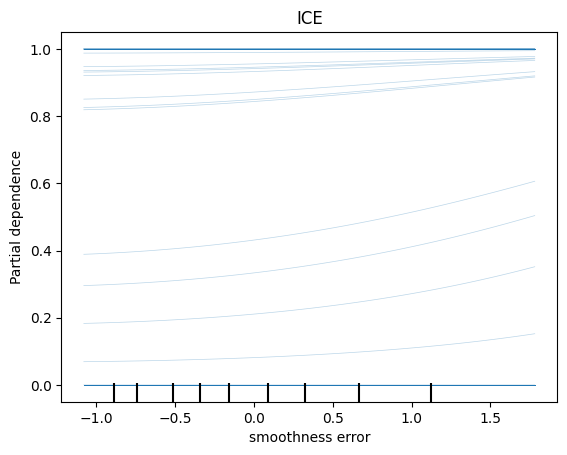

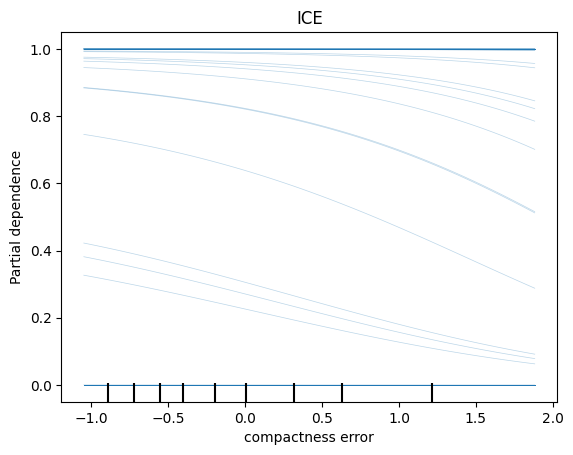

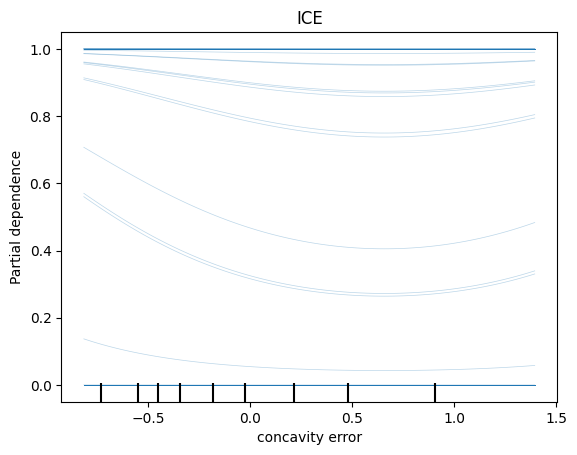

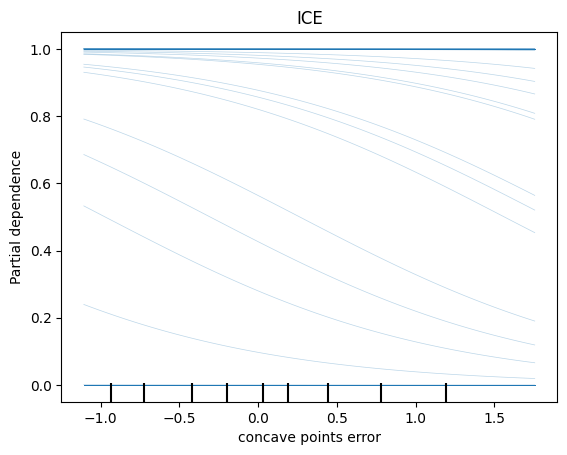

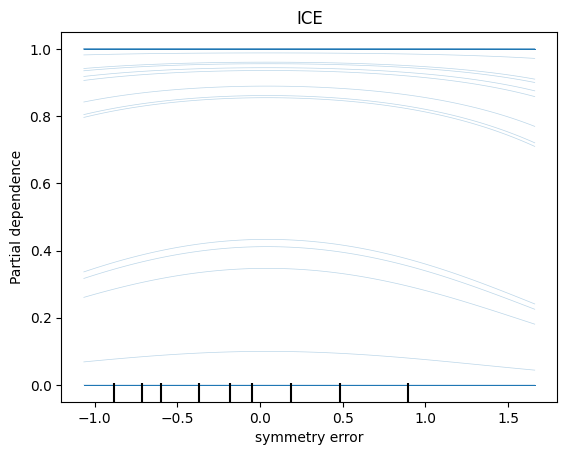

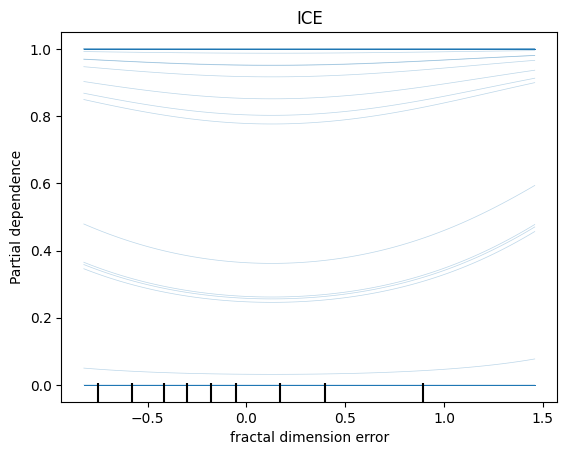

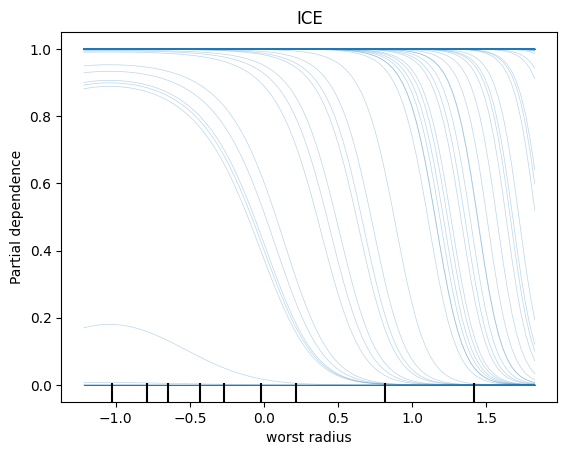

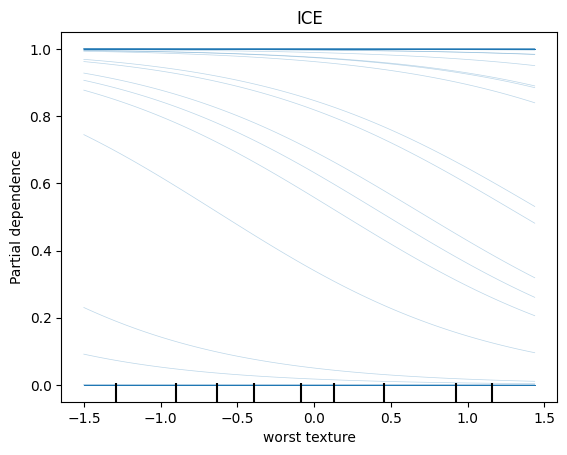

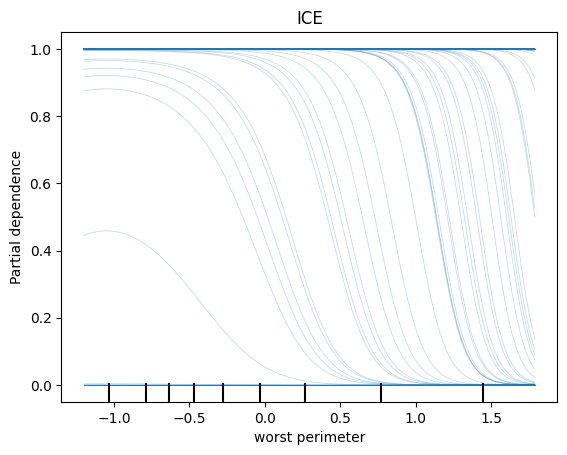

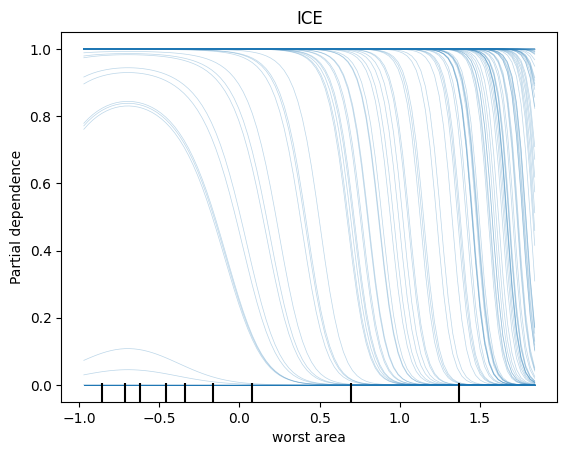

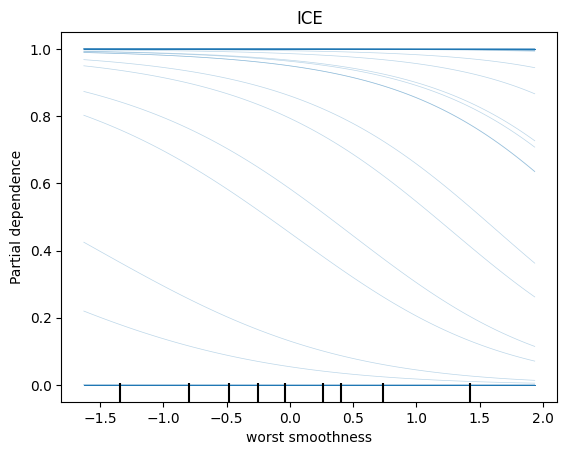

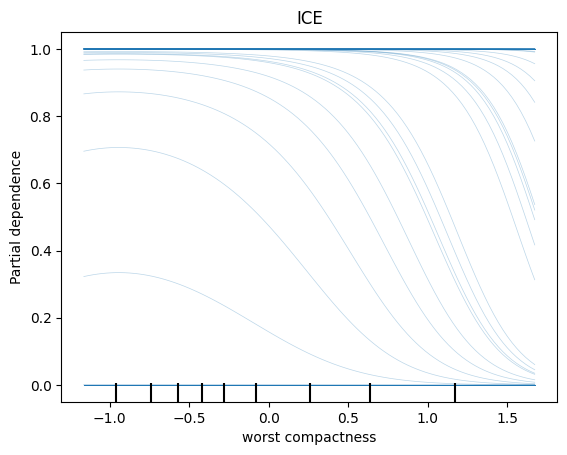

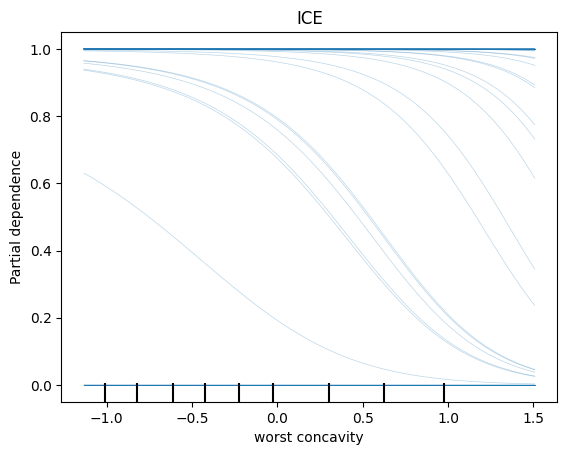

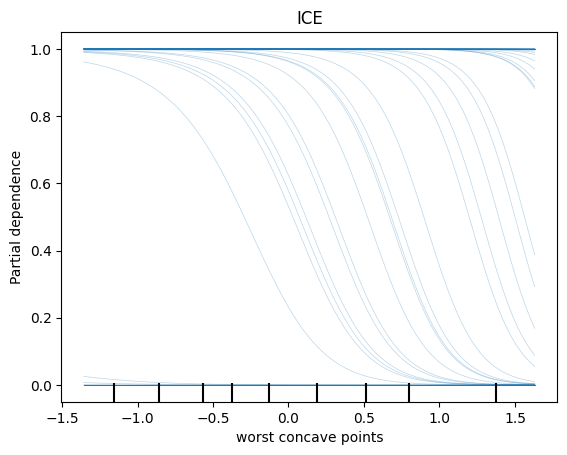

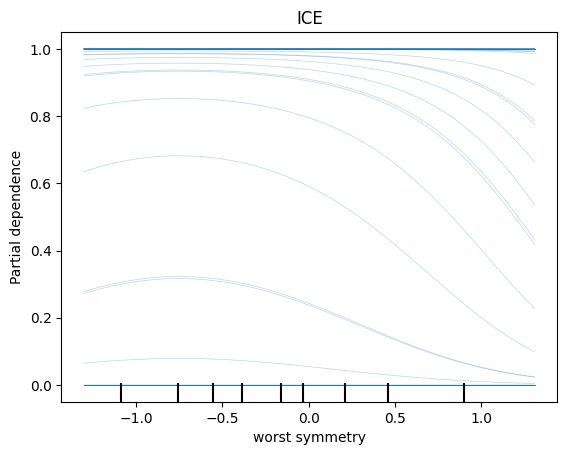

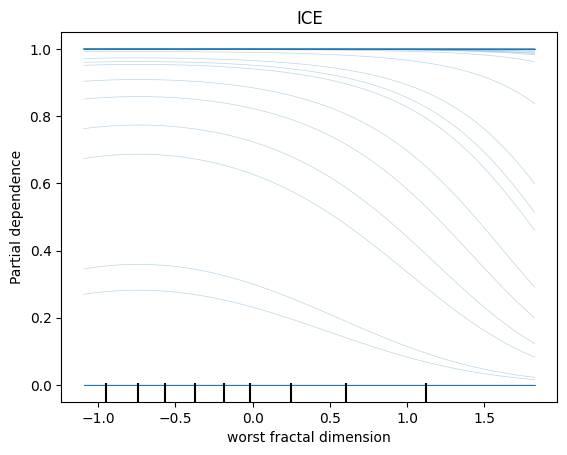

In [ ]:
for feature in X.columns.tolist():
    PartialDependenceDisplay.from_estimator(nb, X_test, features=[feature], target=0, kind='individual')
    plt.title("ICE")
    plt.show()

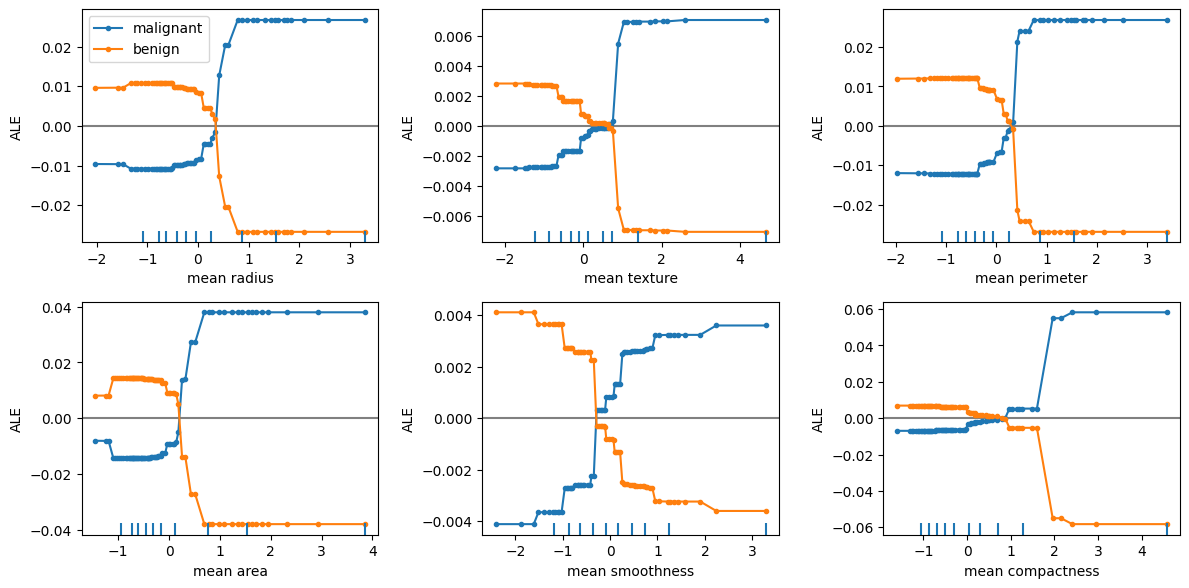

In [ ]:
proba_fun_nb = nb.predict_proba
proba_ale_nb = ALE(proba_fun_nb, feature_names=X_train.columns.tolist()[0:6], target_names=data.target_names)
proba_exp_nb = proba_ale_nb.explain(X_train.values)

plot_ale(proba_exp_nb, n_cols=3, fig_kw={'figwidth': 12, 'figheight': 6}, sharey=True)
plt.show()

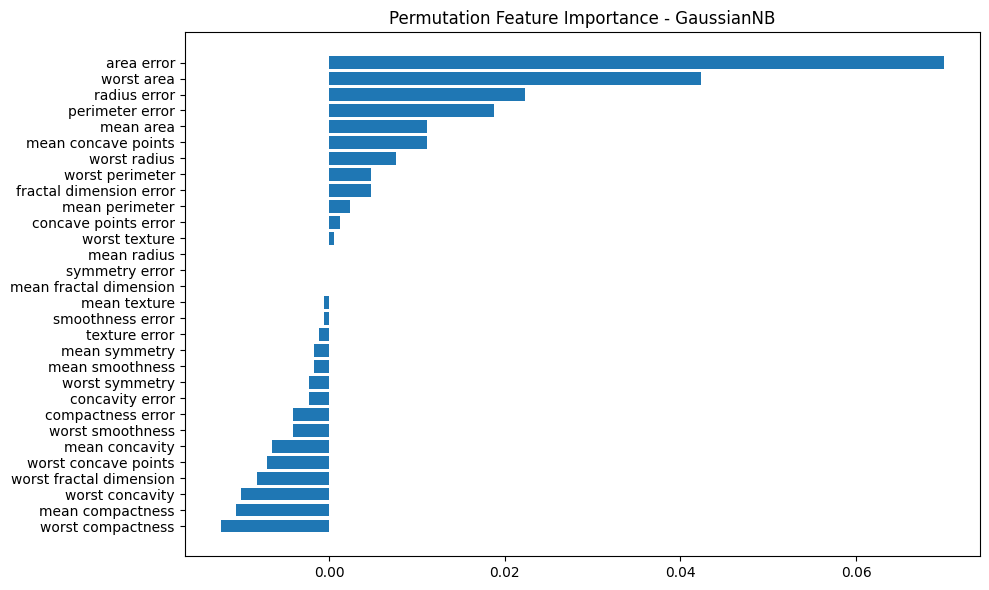

In [ ]:
result = permutation_importance(nb, X_test, y_test, n_repeats=10, random_state=42,scoring='accuracy')

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh([X.columns[i] for i in sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance - GaussianNB")
plt.tight_layout()
plt.show()

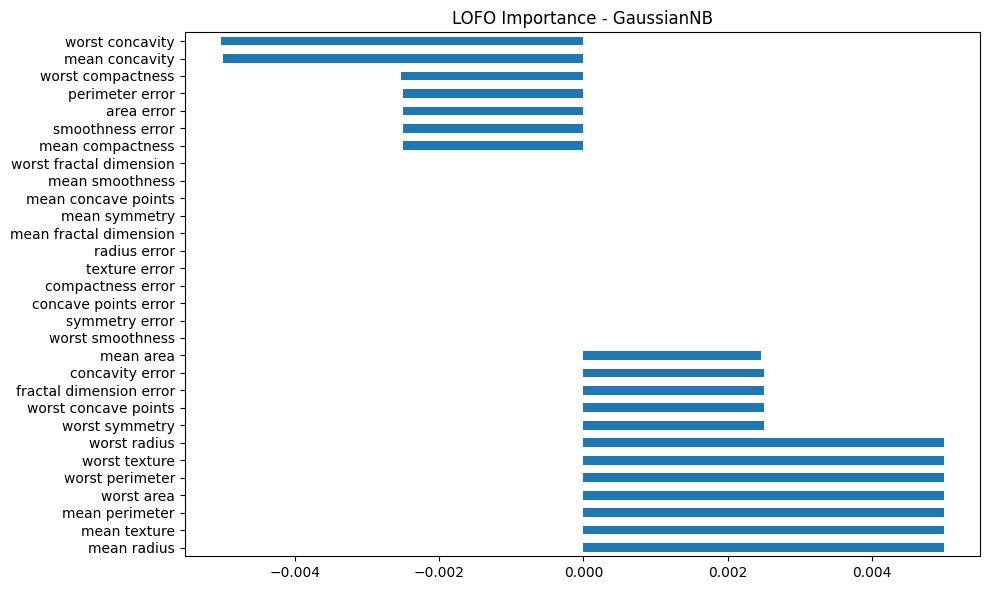

In [ ]:
baseline = cross_val_score(nb, X_train, y_train, cv=5).mean()

lofo_scores = {}
for col in X_train.columns:
    X_lofo = X_train.drop(columns=[col])
    score = cross_val_score(nb, X_lofo, y_train, cv=5).mean()
    lofo_scores[col] = baseline - score

lofo_df = pd.Series(lofo_scores).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
lofo_df.plot(kind='barh')
plt.title("LOFO Importance - GaussianNB")
plt.tight_layout()
plt.show()

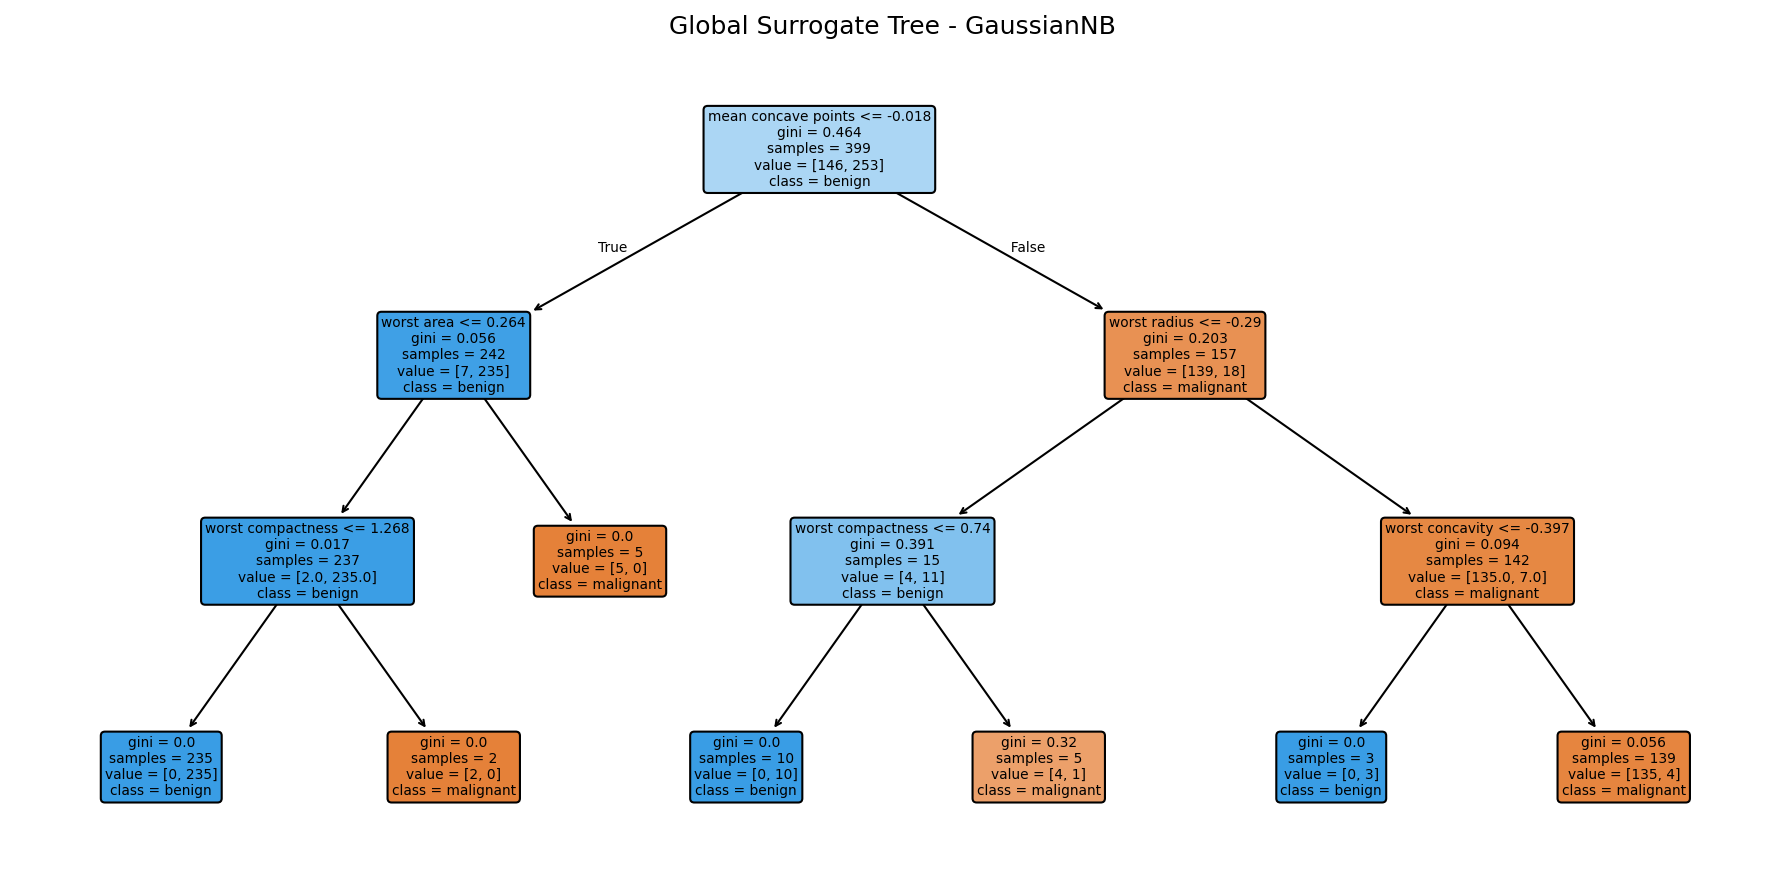

In [ ]:
nb_preds = nb.predict(X_train)
surrogate = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate.fit(X_train, nb_preds)

plt.figure(figsize=(12, 6), dpi=150)
tree.plot_tree(surrogate, feature_names=X.columns.tolist(), filled=True, rounded=True, class_names=data.target_names)
plt.title("Global Surrogate Tree - GaussianNB")
plt.tight_layout()
plt.show()

In [ ]:
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
import random

In [ ]:
random.seed(8)
X_exp = random.choices(X_train.values.tolist(), k=100)
X_exp = pd.DataFrame(X_exp, columns=X.columns)

h_stat = FriedmanHStatisticMethod()
h_stat.fit(nb, X_exp)

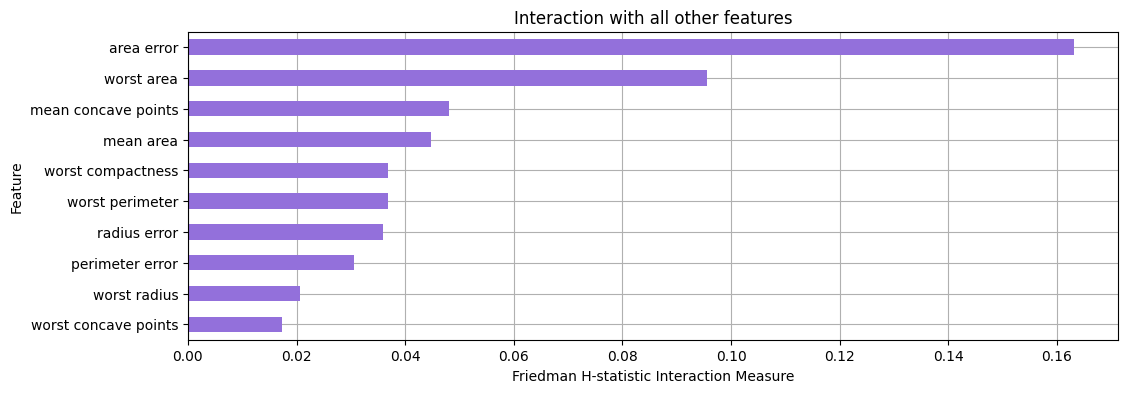

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
h_stat.plot('bar_chart_ova',ax=ax)

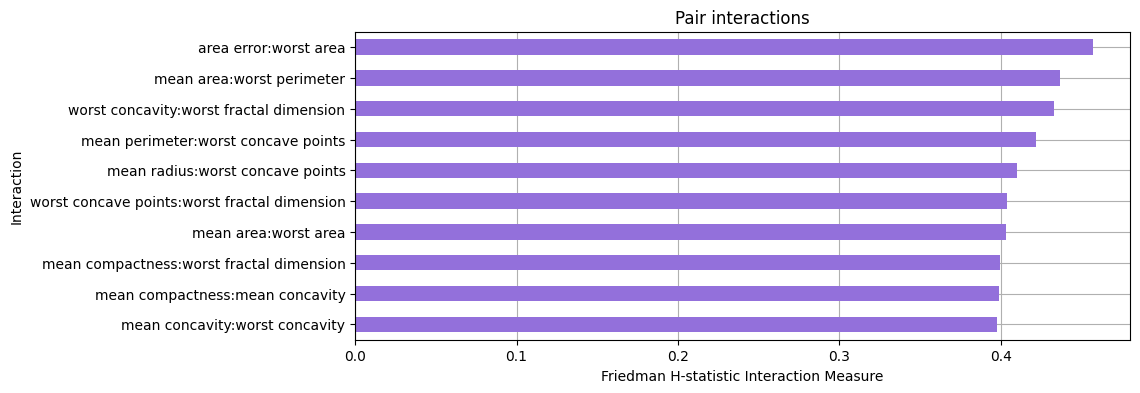

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
h_stat.plot(vis_type='bar_chart',ax=ax)

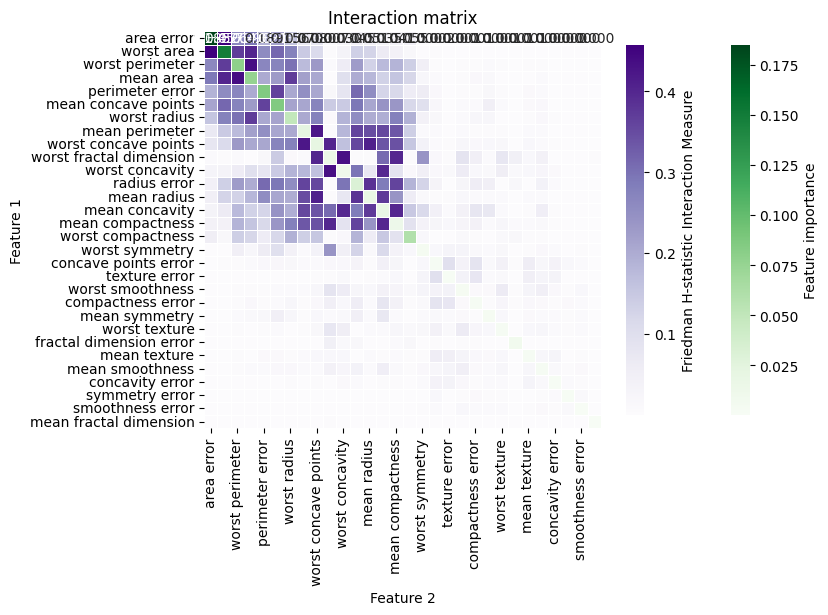

In [ ]:
h_stat.plot()

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=data.target_names.tolist(),
    mode='classification',
    discretize_continuous=True
)

In [ ]:
exp = explainer.explain_instance(data_row=X_test.iloc[0],predict_fn=nb.predict_proba,num_features=len(X.columns))
exp.show_in_notebook(show_table=True, show_all=False)

  0%|          | 0/170 [00:00<?, ?it/s]

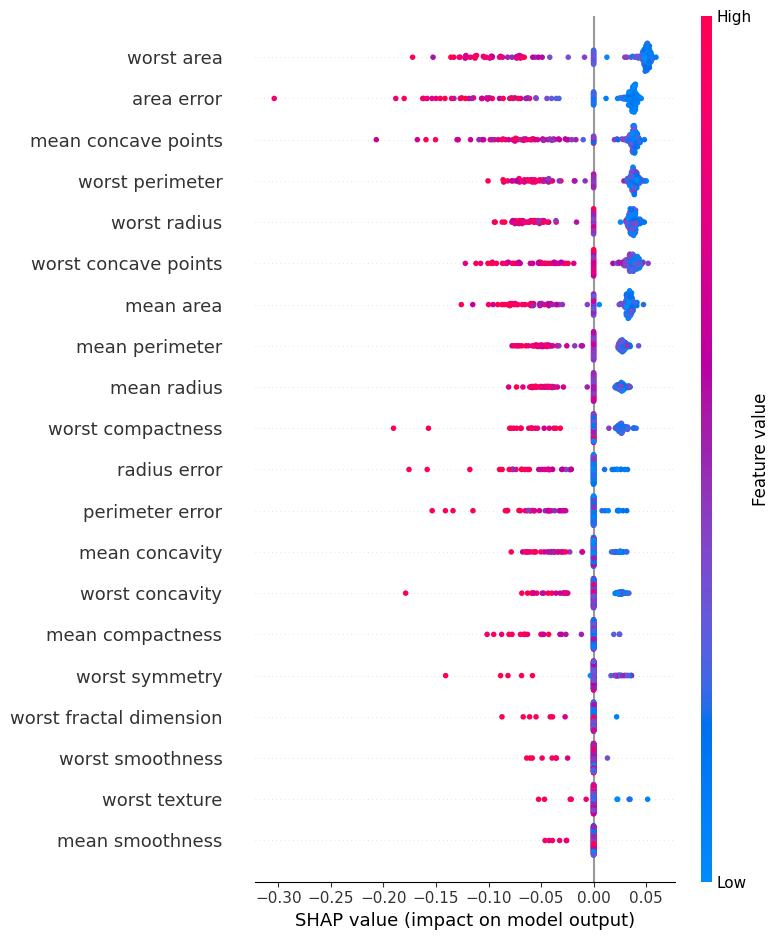

In [ ]:
feature_names = X.columns

background_data = shap.sample(X_train, 100)

explainer = shap.KernelExplainer(nb.predict_proba, background_data)

shap_values = explainer.shap_values(X_test)

plt.figure()
shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=feature_names, show=True)
plt.show()

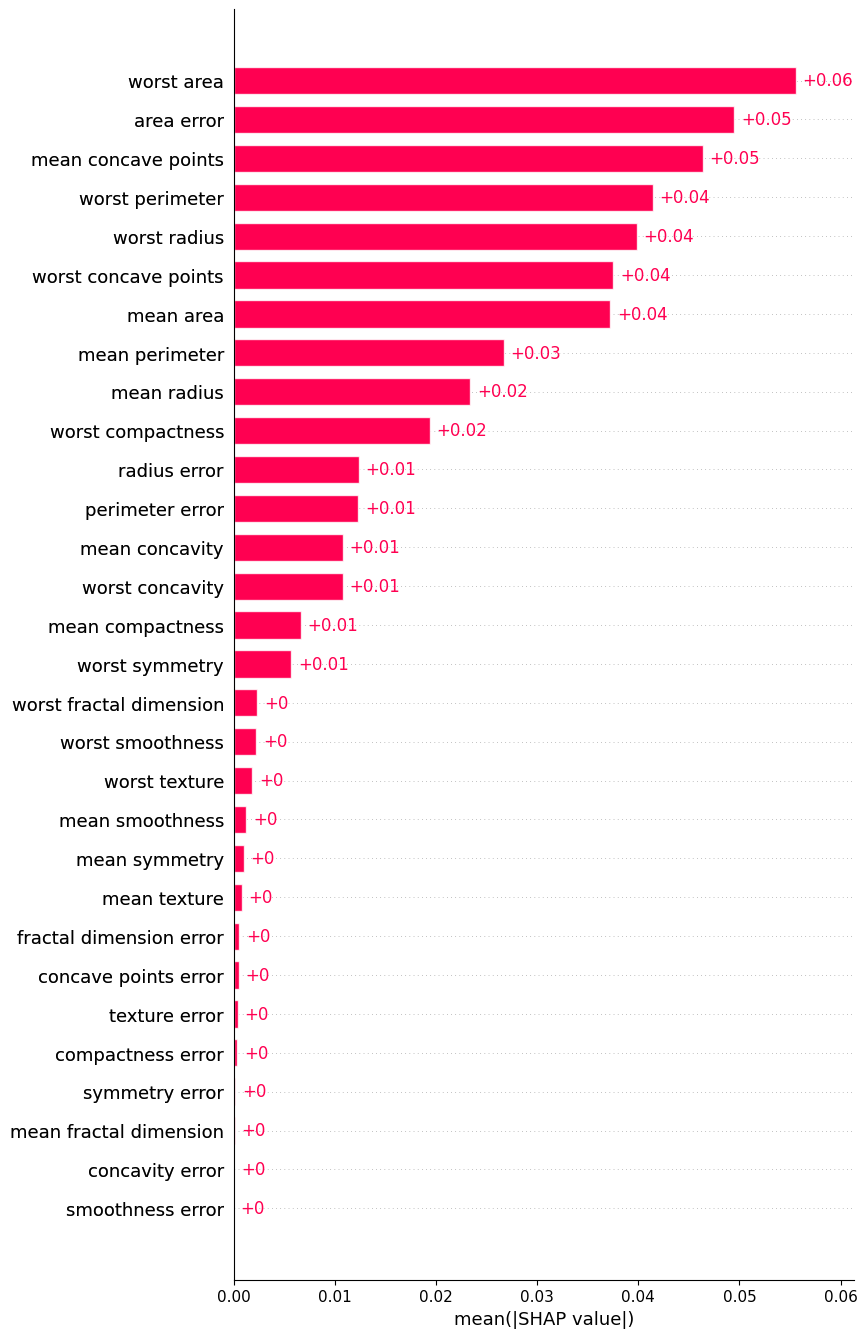

In [ ]:
plt.figure()
shap.plots.bar(explanation, max_display=num_features, show=True)
plt.close()

In [ ]:
explanation = shap.Explanation(
    values=shap_values[:, :, 1],
    base_values=explainer.expected_value[1],
    data=X_test,
    feature_names=feature_names
)

num_features = len(feature_names)

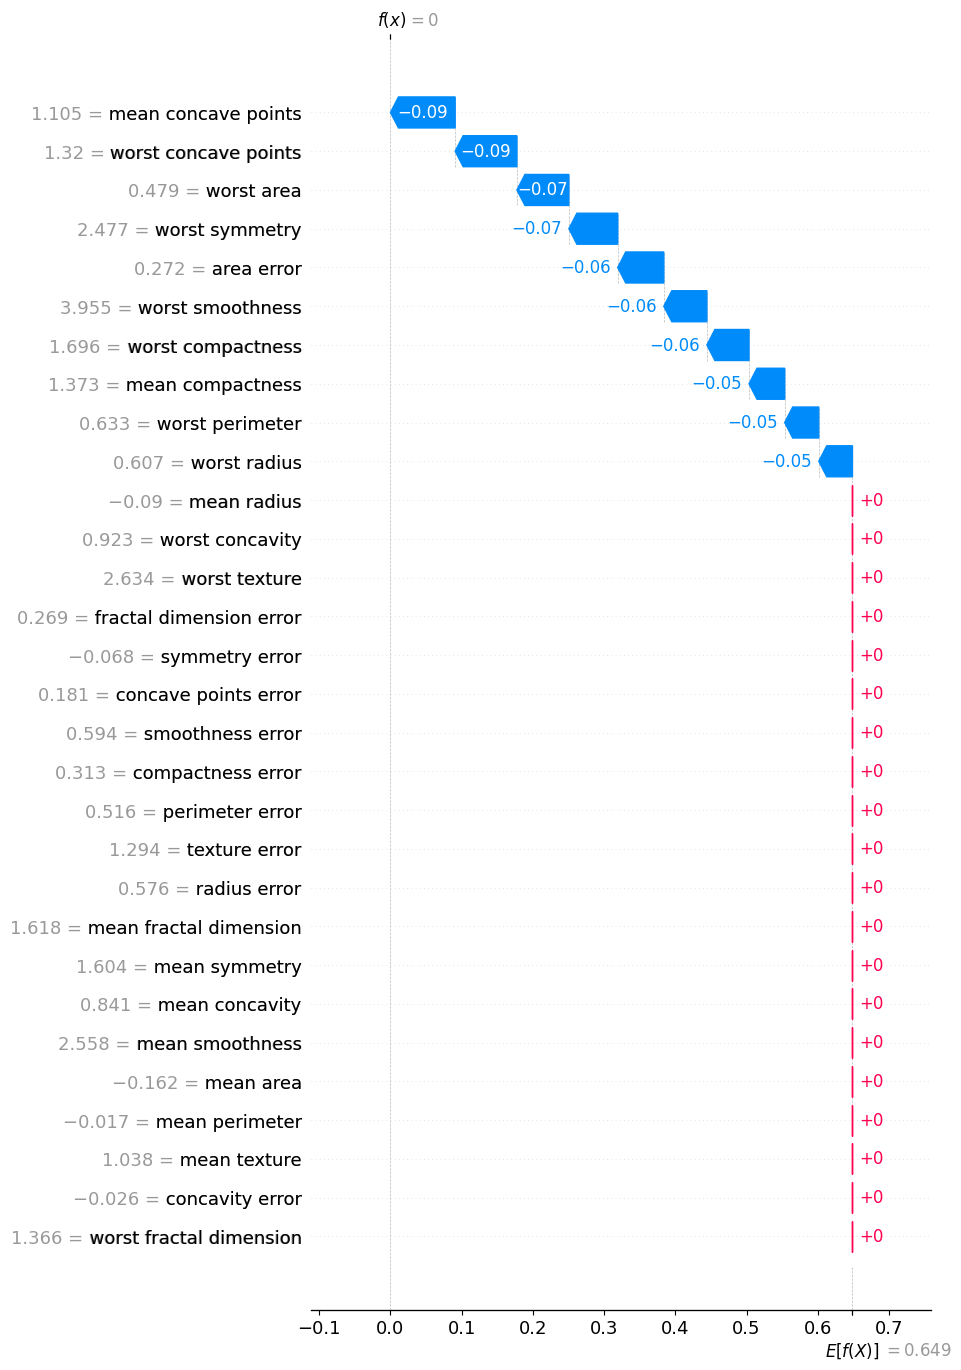

In [ ]:
plt.figure()
shap.plots.waterfall(explanation[0], max_display=num_features, show=True)
plt.close()

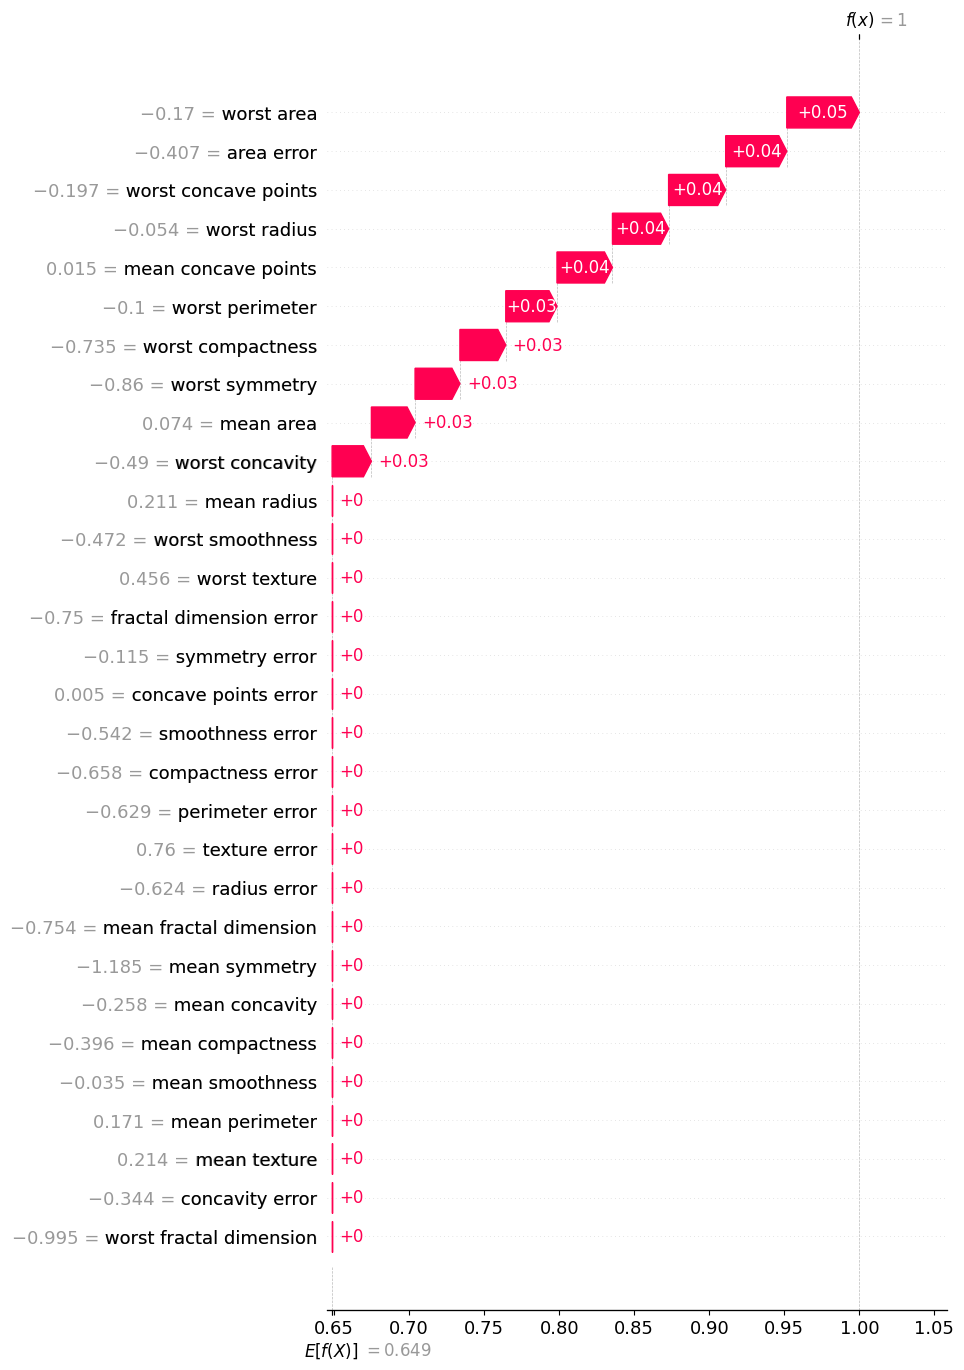

In [ ]:
plt.figure()
shap.plots.waterfall(explanation[1], max_display=num_features, show=True)
plt.close()

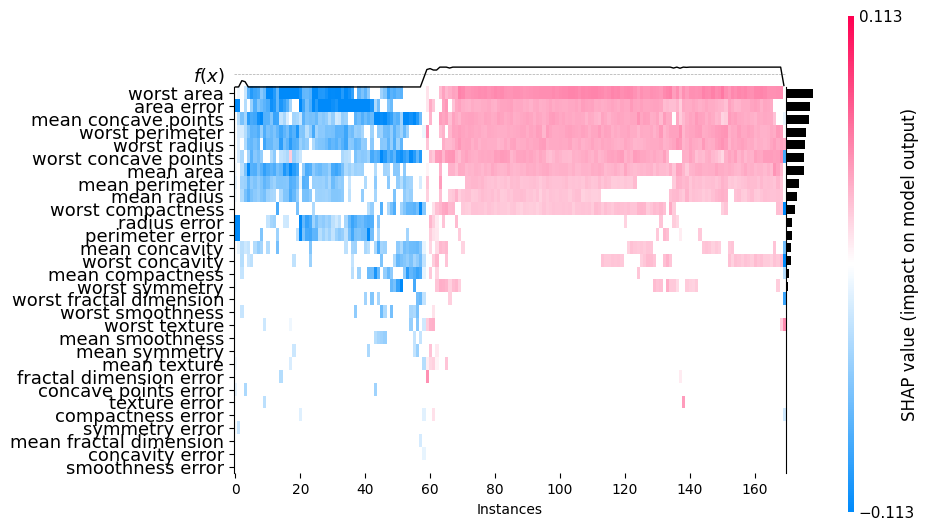

In [ ]:
plt.figure()
shap.plots.heatmap(explanation, max_display=num_features, show=True)
plt.close()